In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from skimage.io import imread, imshow


##Import any other packages you may need here

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

DATAPATH = '/home/danielchan/Chest_Xray_Data/'

all_xray_df = pd.read_csv(DATAPATH+'Data_Entry_2017.csv')
all_xray_df.sample(3)

#data_sample = pd.read_csv('sample_labels.csv')
#data_sample.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
93443  00023377_000.png     No Finding            0       23377           29   
17181  00004605_016.png       Effusion           16        4605           17   
39458  00010338_002.png     No Finding            2       10338           69   

      Patient Gender View Position  OriginalImage[Width  Height]  \
93443              F            PA                 2048     2500   
17181              M            PA                 2992     2991   
39458              M            PA                 2992     2829   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
93443                        0.168  0.168          NaN  
17181                        0.143  0.143          NaN  
39458                        0.143  0.143          NaN

**find the number of unique patients**

In [3]:
print ( "Number of Unique Patients: ", len(np.unique( all_xray_df['Patient ID'].values ) ) )

Number of Unique Patients:  30805


In [4]:
#data_sample['Patient Age'] = data_sample['Patient Age'].map(lambda x: str(x)[:-1]).astype(int)

**Let's look the demographic dsitribution for age and gender**

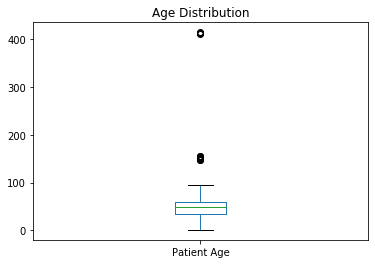

In [5]:
all_xray_df['Patient Age'].plot(kind='box',title='Age Distribution')

**There are some outliners in the data (highly unlikely to have a 414 years old person), we will narrow the age group to 1 standard deviations from the mean**

In [6]:
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

In [7]:
factor = 1.0
pMean = all_xray_df['Patient Age'].mean()
pstd  = all_xray_df['Patient Age'].std()
pAgeLower = int(pMean - factor*pstd)
pAgeUpper = int(pMean + factor*pstd)

print ("Lower and Upper Bound for Age:",pAgeLower, pAgeUpper)

Lower and Upper Bound for Age: 30 63


In [8]:
filtered = all_xray_df[ (all_xray_df['Patient Age'] >= pAgeLower) &  
                        (all_xray_df['Patient Age'] <= pAgeUpper)  ]

In [9]:
print ( filtered.shape[0]/all_xray_df.shape[0]*100, "% of the data set" )

66.34944702104887 % of the data set


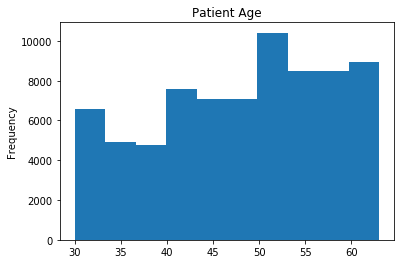

In [10]:
filtered['Patient Age'].plot(kind='hist',title='Patient Age')

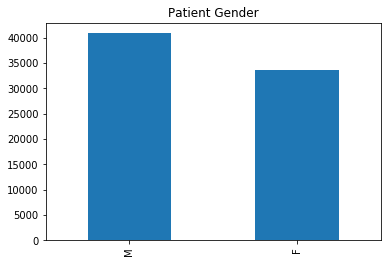

In [11]:
filtered['Patient Gender'].value_counts().plot(kind='bar',title='Patient Gender')

In [12]:
filtered['Patient Gender'].value_counts()

M    40879
F    33512
Name: Patient Gender, dtype: int64

In [13]:
# remove the original dataframe to preserve memory
del all_xray_df

**Both age and gender distributions look good, i.e. it is balanced**

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

### Extract training data set for Pneumonia

In [14]:
all_labels = np.unique(list(chain(*filtered['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        filtered[c_label] = filtered['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
filtered.sample(5)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index                       Finding Labels  Follow-up #  \
46800  00011945_002.png                           No Finding            2   
6829   00001836_015.png  Consolidation|Fibrosis|Infiltration           15   
30887  00008044_000.png                           No Finding            0   
75156  00018443_000.png                               Nodule            0   
81777  00020113_033.png           Consolidation|Infiltration           33   

       Patient ID  Patient Age Patient Gender View Position  \
46800       11945           33              F            AP   
6829         1836           49              F            AP   
30887        8044           45              M            PA   
75156       18443           58              M            PA   
81777       20113           38              M            AP   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
46800                 2500     2048                        0.168  ...   
6829                  2500     2048                        0.168  ...   
30887                 2500     2048                        0.168  ...   
75156                 2500     2048                        0.168  ...   
81777                 3056     2544                        0.139  ...   

       Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
46800        0.0       0.0     0.0           0.0   0.0         1.0     0.0   
6829         0.0       1.0     0.0           1.0   0.0         0.0     0.0   
30887        0.0       0.0     0.0           0.0   0.0         1.0     0.0   
75156        0.0       0.0     0.0           0.0   0.0         0.0     1.0   
81777        0.0       0.0     0.0           1.0   0.0         0.0     0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  
46800                 0.0        0.0           0.0  
6829                  0.0        0.0           0.0  
30887                 0.0        0.0           0.0  
75156                 0.0        0.0           0.0  
81777                 0.0        0.0           0.0  

[5 rows x 27 columns]

In [15]:
len(all_labels)

15

**Let's find out more about No Finding, Number of Pneumonia Cases, Unique Patient IDs and View Positions**

In [16]:
filtered['No Finding'].value_counts()

1.0    40376
0.0    34015
Name: No Finding, dtype: int64

In [17]:
filtered['Pneumonia'].value_counts()

0.0    73499
1.0      892
Name: Pneumonia, dtype: int64

In [18]:
filtered[ filtered['Pneumonia']==1]['View Position'].value_counts()

AP    489
PA    403
Name: View Position, dtype: int64

In [19]:
# number of unique patients with Pneumonia
len (np.unique( filtered[ filtered['Pneumonia']==1]['Patient ID'].values ))

644

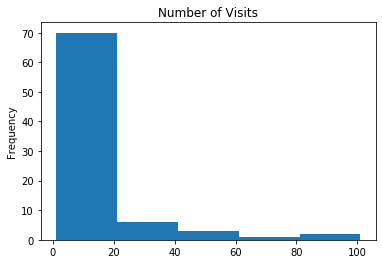

In [20]:
# look at how many repeat visits are there
filtered[ filtered['Pneumonia']==1]['Follow-up #'].value_counts().plot(kind='hist',bins=5,title="Number of Visits")

In [21]:
filtered[ filtered['Pneumonia']==1]['Follow-up #'].value_counts().describe()

count     82.000000
mean      10.878049
std       18.867563
min        1.000000
25%        1.000000
50%        3.000000
75%        9.750000
max      101.000000
Name: Follow-up #, dtype: float64

**75% of positive Pneumonia cases have less than 10 visits**

### Let's look at the age distribution for different diseases

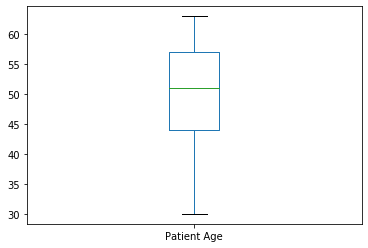

In [22]:
# for Atelectasis

filtered[filtered['Atelectasis']==1]['Patient Age'].plot(kind='box')

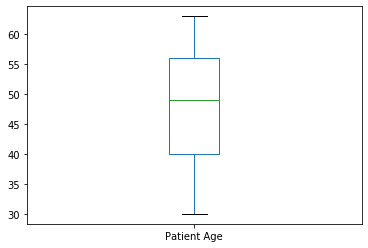

In [23]:
# for Edema

filtered[filtered['Edema']==1]['Patient Age'].plot(kind='box')

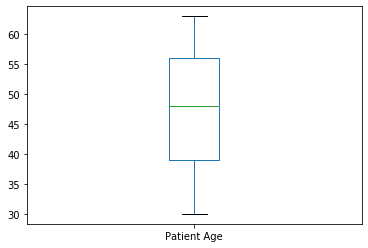

In [24]:
# for Pneumonia

filtered[filtered['Pneumonia']==1]['Patient Age'].plot(kind='box')

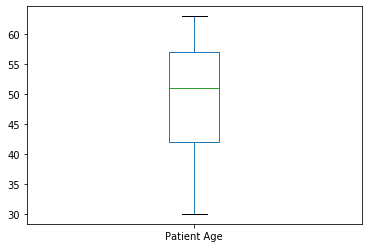

In [25]:
# for Effusion

filtered[filtered['Effusion']==1]['Patient Age'].plot(kind='box')

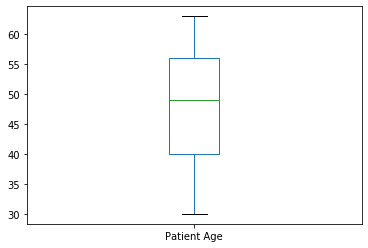

In [26]:
# for Infiltration

filtered[filtered['Infiltration']==1]['Patient Age'].plot(kind='box')

In [28]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['Follow-up #'].value_counts().describe()

count    76.000000
mean      8.131579
std      12.179044
min       1.000000
25%       1.000000
50%       2.500000
75%       8.000000
max      54.000000
Name: Follow-up #, dtype: float64

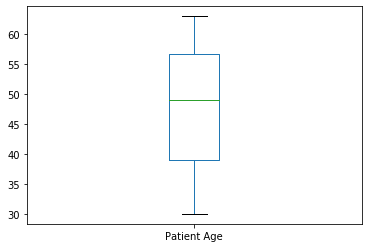

In [29]:
# Age distribution for those who have Pneumonia and one other disease

filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['Patient Age'].plot(kind='box')

In [30]:
filtered[   (filtered['Infiltration']==1)   |
            (filtered['Effusion']==1)       |
            (filtered['Edema']==1 )         |
            (filtered['Atelectasis']==1)       ]['Pneumonia'].value_counts()

0.0    23361
1.0      618
Name: Pneumonia, dtype: int64

# Describe how to set up the model training based on the findings

In [43]:
## frequency of co-occurence with other diseases

for d in all_labels:
    print ( d," ",filtered [ (filtered['Pneumonia']==1) & (filtered[d]==1)].shape[0]/892. )

Atelectasis   0.20291479820627803
Cardiomegaly   0.030269058295964126
Consolidation   0.09865470852017937
Edema   0.242152466367713
Effusion   0.1961883408071749
Emphysema   0.013452914798206279
Fibrosis   0.010089686098654708
Hernia   0.0033632286995515697
Infiltration   0.4024663677130045
Mass   0.05493273542600897
No Finding   0.0
Nodule   0.05493273542600897
Pleural_Thickening   0.034753363228699555
Pneumonia   1.0
Pneumothorax   0.034753363228699555


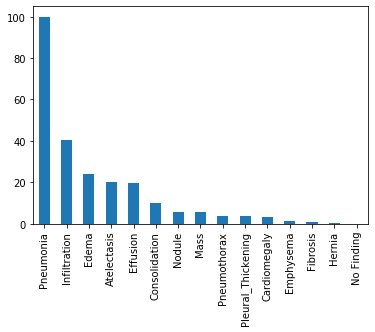

In [44]:
occur ={}
for d in all_labels:
    occur[d] = filtered [ (filtered['Pneumonia']==1) & (filtered[d]==1)].shape[0]/892.*100. 
series = pd.Series(occur).sort_values(ascending=False)
series.plot(kind='bar')

**Top 4 most common comorbidities are: Infiltration, Edema, Atelectasis​ and Effusion**

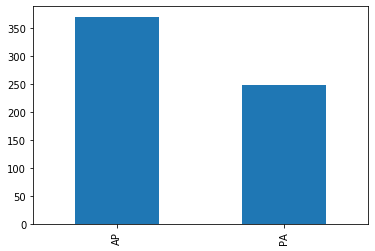

In [33]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['View Position'].value_counts().plot(kind='bar')

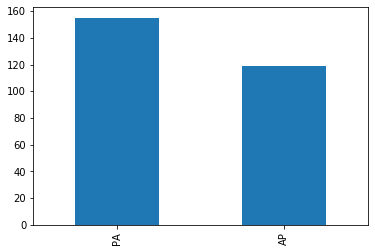

In [61]:
filtered[ (filtered['Pneumonia']==1)    &
          ( (filtered['Infiltration']==0) &
            (filtered['Effusion']==0)     &
            (filtered['Edema']==0 )       &
            (filtered['Atelectasis']==0) )]['View Position'].value_counts().plot(kind='bar')

**It looks like AP (anteroposterior) view produces more positive Pneumonia cases**

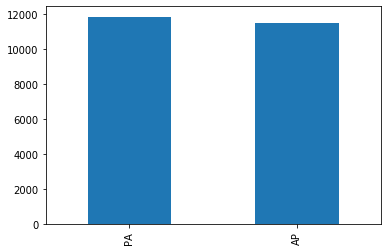

In [34]:
filtered[ (filtered['Pneumonia']==0)    &
          ( (filtered['Infiltration']==1) |
            (filtered['Effusion']==1)     |
            (filtered['Edema']==1 )       |
            (filtered['Atelectasis']==1) )]['View Position'].value_counts().plot(kind='bar')

In [35]:
filtered.head(5)

Image Index          Finding Labels  Follow-up #  Patient ID  \
0   00000001_000.png            Cardiomegaly            0           1   
1   00000001_001.png  Cardiomegaly|Emphysema            1           1   
2   00000001_002.png   Cardiomegaly|Effusion            2           1   
38  00000013_000.png              No Finding            0          13   
39  00000013_001.png  Emphysema|Pneumothorax            1          13   

    Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0            58              M            PA                 2682     2749   
1            58              M            PA                 2894     2729   
2            58              M            PA                 2500     2048   
38           61              M            PA                 2021     2021   
39           60              M            AP                 3056     2544   

    OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
0                      0.143000  ...        0.0       0.0     0.0   
1                      0.143000  ...        1.0       0.0     0.0   
2                      0.168000  ...        0.0       0.0     0.0   
38                     0.194311  ...        0.0       0.0     0.0   
39                     0.139000  ...        1.0       0.0     0.0   

    Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
0            0.0   0.0         0.0     0.0                 0.0        0.0   
1            0.0   0.0         0.0     0.0                 0.0        0.0   
2            0.0   0.0         0.0     0.0                 0.0        0.0   
38           0.0   0.0         1.0     0.0                 0.0        0.0   
39           0.0   0.0         0.0     0.0                 0.0        0.0   

    Pneumothorax  
0            0.0  
1            0.0  
2            0.0  
38           0.0  
39           1.0  

[5 rows x 27 columns]

In [36]:

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(DATAPATH,'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', filtered.shape[0])
filtered['path'] = filtered['Image Index'].map(all_image_paths.get)
filtered.sample(3)



Scans found: 112120 , Total Headers 74391


Image Index                     Finding Labels  Follow-up #  \
32598   00008522_021.png                       Infiltration           21   
96042   00025261_004.png  Atelectasis|Effusion|Infiltration            4   
100589  00026697_000.png                         No Finding            0   

        Patient ID  Patient Age Patient Gender View Position  \
32598         8522           61              F            AP   
96042        25261           58              F            PA   
100589       26697           45              F            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
32598                  2500     2048                        0.168  ...   
96042                  2754     2665                        0.143  ...   
100589                 2702     2577                        0.143  ...   

        Fibrosis  Hernia  Infiltration  Mass  No Finding  Nodule  \
32598        0.0     0.0           1.0   0.0         0.0     0.0   
96042        0.0     0.0           1.0   0.0         0.0     0.0   
100589       0.0     0.0           0.0   0.0         1.0     0.0   

        Pleural_Thickening  Pneumonia  Pneumothorax  \
32598                  0.0        0.0           0.0   
96042                  0.0        0.0           0.0   
100589                 0.0        0.0           0.0   

                                                     path  
32598   /home/danielchan/Chest_Xray_Data/images_004/im...  
96042   /home/danielchan/Chest_Xray_Data/images_011/im...  
100589  /home/danielchan/Chest_Xray_Data/images_011/im...  

[3 rows x 28 columns]

## Look at pixel intensitites for different diseases

In [55]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100

# for Pneumonia

samp = filtered[(filtered['Pneumonia']==1 ) &
                (filtered['View Position']=="PA")  
               ].sample(5)['path'].values

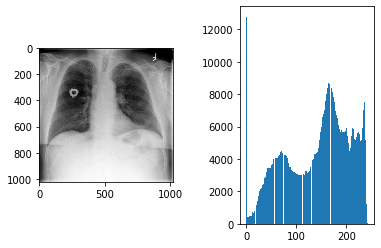

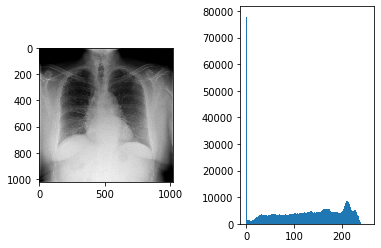

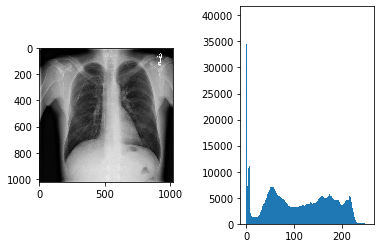

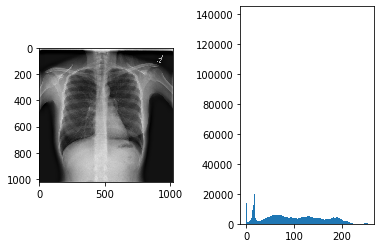

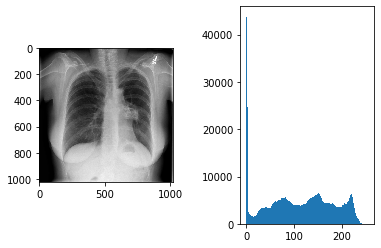

In [56]:
for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(pic.ravel(), bins = 256)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

#plt.figure(figsize=(5,5))
#plt.hist(dcm.pixel_array.ravel(), bins = 256)

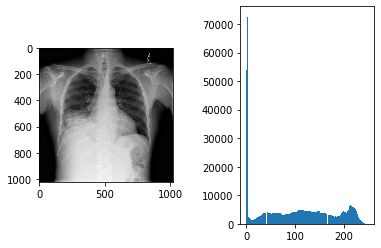

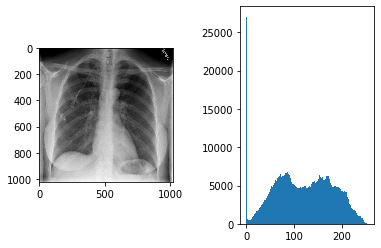

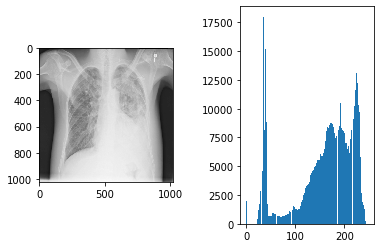

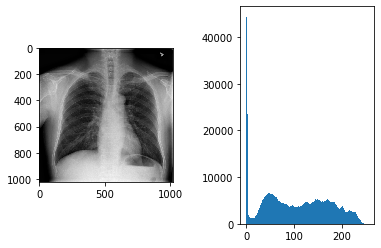

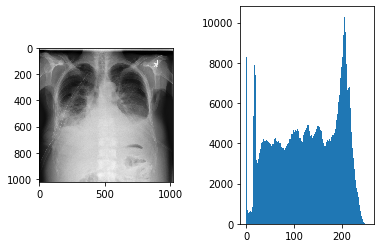

In [57]:
# for Infiltration

samp = filtered[(filtered['Infiltration']==1 ) &
                (filtered['View Position']=="PA")  
               
               ].sample(5)['path'].values

for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(pic.ravel(), bins = 256)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

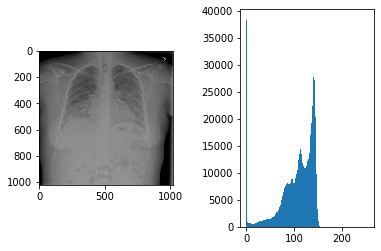

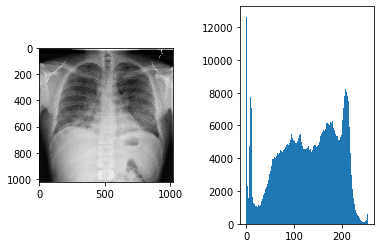

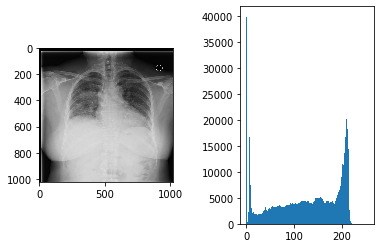

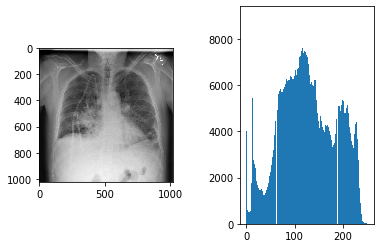

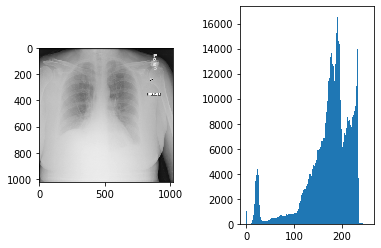

In [58]:
samp = filtered[(filtered['Edema']==1 ) &
                (filtered['View Position']=="PA")  
               ].sample(5)['path'].values

for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(pic.ravel(), bins = 256)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

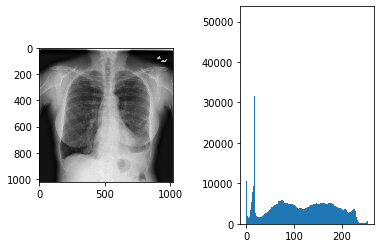

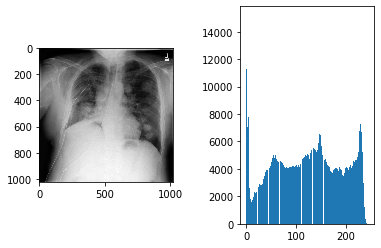

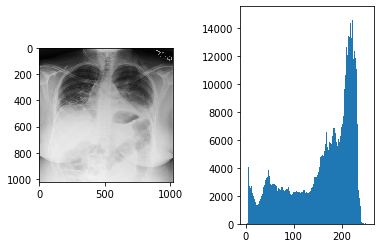

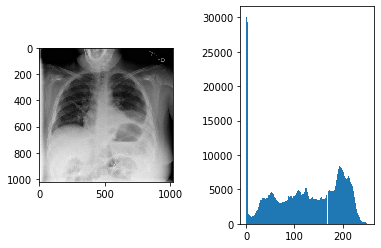

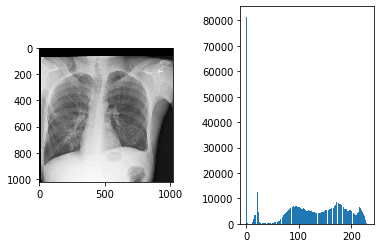

In [59]:
samp = filtered[ 
                    (filtered['View Position']=="PA")  &
    (filtered['Effusion']==1) ].sample(5)['path'].values

for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(pic.ravel(), bins = 256)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

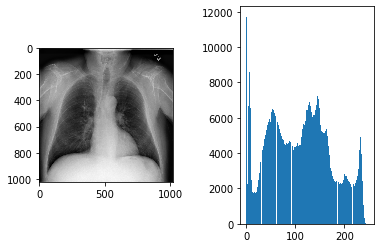

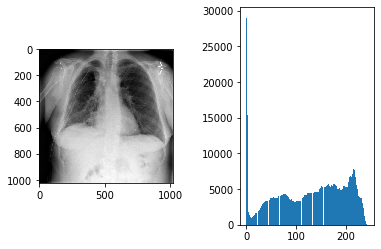

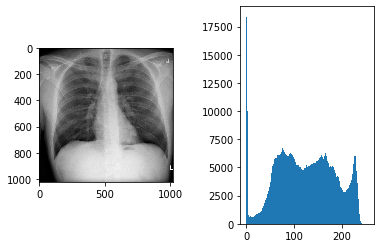

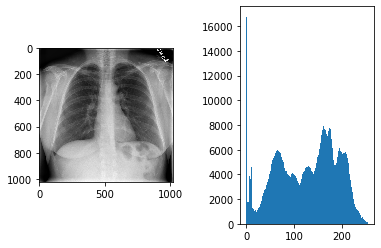

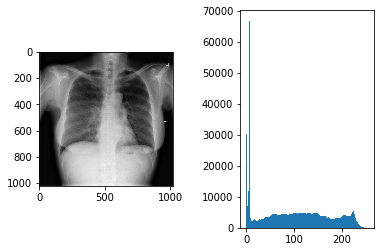

In [60]:
samp = filtered[ 
                    (filtered['View Position']=="PA")  &

                    (filtered['Atelectasis']==0) ].sample(5)['path'].values

for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(pic.ravel(), bins = 256)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

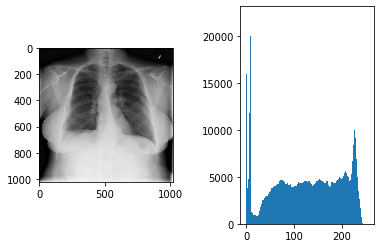

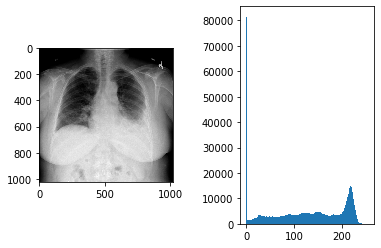

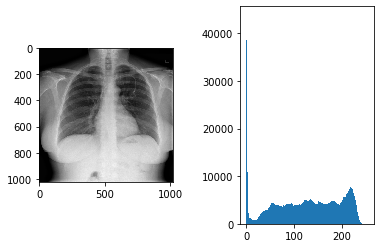

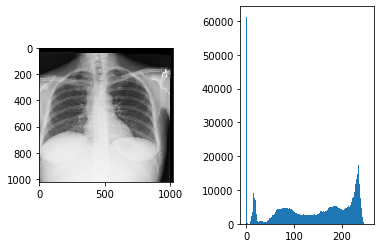

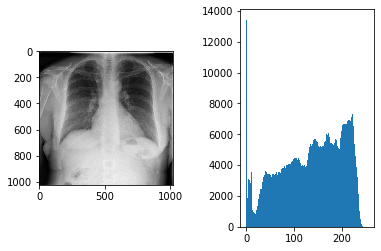

In [54]:
samp = filtered[ (filtered['No Finding']==0)  &
                 (filtered['View Position']=="PA")].sample(5)['path'].values

for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(pic.ravel(), bins = 256)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()

In [62]:
# look at the possibility of removing the impact of other diseases

filtered2 = filtered[ (filtered['Pneumonia']==1)    &
            ((filtered['Infiltration']==0)          &
            (filtered['Effusion']==0)               &
            (filtered['Edema']==0 )                 &
            (filtered['Atelectasis']==0) )          &
            (filtered['View Position']=="PA") ]

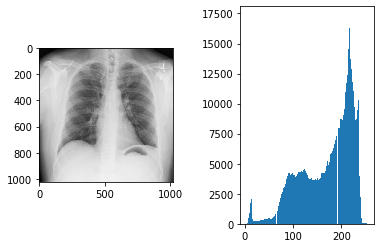

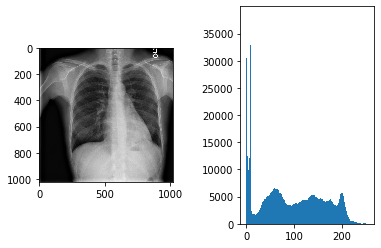

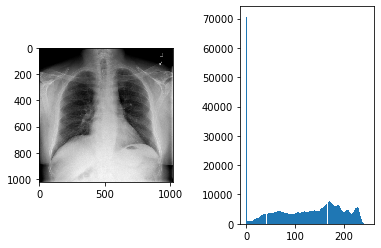

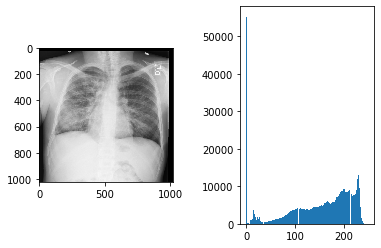

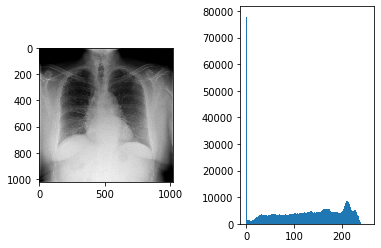

In [65]:
samp = filtered2.sample(5)['path'].values

for img in samp:
    plt.subplot(1, 2, 1)
    pic = imread( img )
    plt.imshow(pic,cmap='gray')
    plt.subplot(1, 2, 2)
    plt.hist(pic.ravel(), bins = 256)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    plt.show()